Run 0-4, skip forward-filling the model (#5), and continue with the rest of the steps to create the missing data matrix. Otherwise run steps 0-5 and skip 7A for the imputed data (continue with the rest of steps).

# Setup environment and install packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/CS229btimeseries/Project/

Mounted at /content/drive
/content/drive/MyDrive/CS229btimeseries/Project


In [ ]:
!ls

 accuracy_training_val
 alternate_copyRNN_LSTM_code_11_15_2023_v3.ipynb
 classification_neuralODE_11_27_23.ipynb
'Copy of rnn_attempt_11_2_2023 (1).ipynb'
'Copy of rnn_attempt_11_2_2023.ipynb'
 CS229B_project_code_11_28_2023.ipynb
 CS229B_project_neuralcde_12_2_2023.ipynb
 CS229B_reduced_ds_RNN_LSTM_12_5_2023.ipynb
 CS229B_RNN_LSTM_12_5_2023.ipynb
 CS229B_RNN_LSTM_12_6_2023.ipynb
 dataset_time_masks_missing_20231206.pt
 featurenames_CS229B_project
 featurenames_sepsis_ds
 format_CS229B_project_data_12_3_2023.ipynb
 my_processed_datasets
 my_RNN_LSTM_code_11_13_2023_v2.ipynb
 open_physionet_data.ipynb
 plot_precision_recall.ipynb
 requirements_cs229b.txt
 sepsis_comp_physionet_2019
 signatory
 trainacc_CDEnew22_lr12.pt
 trainacc_CDEnew22_lr13.pt
 trainacc_CDEnew42_lr12.pt
 trainacc_CDEnew42.pt
 trainacc_CDEnew84_lr12.pt
 trainacc_CDE.pt
 trainacc_LSTMbest.pt
 trainacc_LSTMnew1.pt
 trainacc_LSTMnew.pt
 trainacc_neuralODEbest.pt
 trainacc_RNNnew.pt
 trainacc_RNN.pt
 trainloss_CDEnew22_lr1

# Install packages to load data

Load the requirements to use the sepsis 2019 PhysioNet winner dataloader/ preprocessing functions.

In [ ]:
!pip uninstall numpy
!pip install -U -r requirements_cs229b.txt

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.10
    /usr/local/lib/python3.10/dist-packages/numpy-1.23.5.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-742d56dc.3.20.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? y
  Successfully uninstalled numpy-1.23.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 477.1/477.1 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 26.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account

# Restart Google Drive to use updated version of numpy (in order to use Sepsis PhysioNet 2019 functions to open data).

In [ ]:
import numpy
print(numpy.__version__)

1.26.1


In [ ]:
! ls

drive  sample_data


In [ ]:
%cd drive/MyDrive/CS229btimeseries/Project/sepsis_comp_physionet_2019
#%cd sepsis_comp_physionet_2019

/content/drive/MyDrive/CS229btimeseries/Project/sepsis_comp_physionet_2019


# Import functions to open data

In [ ]:
import sys; sys.path.insert(0, '../../')
from definitions import *
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from src.data.dataset import TimeSeriesDataset, ListDataset
from src.data.functions import torch_ffill
from src.features.derived_features import shock_index, partial_sofa
from src.model.model_selection import stratified_kfold_cv
from src.model.nets import RNN
from src.model.optimizer import optimize_utility_threshold, compute_utility_from_indexes

In [ ]:
from src.visualization import general

In [ ]:
from IPython.lib.pretty import PrettyPrinter
## Added my own function

def torch_bfill(data):
    """ Backward fill for a torch tensor.

    Input: torch tensor input of shape [N, L, C] and will backward along the 2nd (L)
    dimension.
    Output: backward-filled torch tensor output of shape [N, L, C] for NaN values

    References: With reference to torch_ffill defined by XXXX.
    """
    def bfill2d(arr):
        """ 2d Backward fill.
        Input: 2d numpy array
        Output: Backfilled 2d numpy array for Nan values"""
        # Convert array to pandas DataFrame array
        arr_pd = pd.DataFrame(arr)
        # Replace nans with None's in order to use pandas backfill function
        arr_pd = arr_pd.replace({np.nan:None})
        # Backfill tensor with pandas
        backfill_arr_pd = arr_pd.bfill(axis=1)
        # Convert dataframe back into array
        backfill_tensor = np.array(backfill_arr_pd.values)
        out = backfill_tensor
        return out

    data_bfilled = torch.Tensor([bfill2d(x.numpy().T) for x in data]).transpose(1, 2)
    return data_bfilled

# Opening data using dataloader functions from sepsis PhysioNet

In [ ]:
# GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 1. Open dataset (features) and sepsis labels

In [ ]:
%cd sepsis_comp_physionet_2019/

[Errno 2] No such file or directory: 'sepsis_comp_physionet_2019/'
/content/drive/MyDrive/CS229btimeseries/Project/sepsis_comp_physionet_2019


In [ ]:
# Load the full dataset
#dataset = TimeSeriesDataset().load('raw/data.tsd')
labels = torch.Tensor(load_pickle('processed/labels/binary.pickle')) #binary.pickle

In [ ]:
num_patients, num_timepoints, total_features = dataset.data.shape

In [ ]:
# Save labels to a file
#torch.save(labels, 'labels.pt')

# 2. Extract some information from raw feature data and create visualizations

In [ ]:
counts_labels = labels.unique(return_counts=True)
proportion_septic = counts_labels[1]/labels.shape[0]
print('Number of septic labels (not =#septic patients):', counts_labels)
print('Proportion of septic v nonseptic labels:', proportion_septic)

Number of septic labels (not =#septic patients): (tensor([0., 1.]), tensor([1524294,   27916]))
Proportion of septic v nonseptic labels: tensor([0.9820, 0.0180])


In [ ]:
input_feature_labels = dataset.columns
#print(input_feature_labels)

In [ ]:
print(dataset.data.shape)

torch.Size([40336, 336, 41])


In [ ]:
dict_nan_values = {}
list_popular_measurements = []
measurements_for_all_patients = []
for idx, item in enumerate(input_feature_labels):
  pd_see_nan = pd.DataFrame(dataset[item].squeeze(2))
  nan_counts_over_time_per_feature = (~pd_see_nan.isna()).sum()
  dict_nan_values[item] = nan_counts_over_time_per_feature
  list_nans = list(nan_counts_over_time_per_feature)
  if all(val > 6000 for val in list_nans[:48]):
    list_popular_measurements.append(item)
  if any(val >40335 for val in list_nans[:1]):
    measurements_for_all_patients.append(item)

print(list_popular_measurements)
print('Initial measurements available from all patients: ', measurements_for_all_patients)
list_popular_measurements.append('Lactate')
list_popular_measurements.append('pH')

['HR', 'O2Sat', 'SBP', 'MAP', 'DBP', 'Resp', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'hospital']
Initial measurements available from all patients:  ['Age', 'Gender', 'ICULOS', 'hospital']


Text(0.5, 1.0, 'Number of patients with available measurements \n for each feature over time')

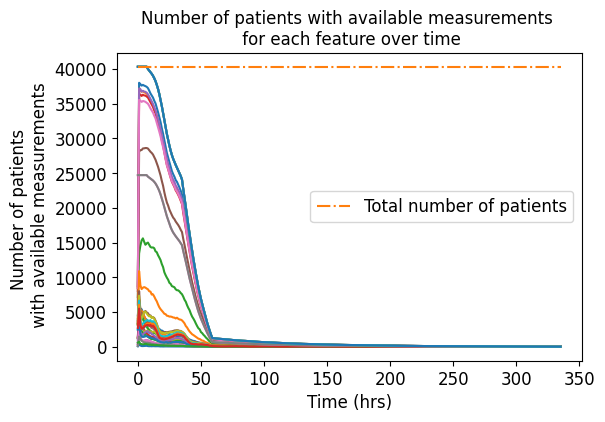

In [ ]:
# Plot all measurements
plt.figure(figsize=(6,4))
D = dict_nan_values
for feature in D.keys():
  plt.plot(D[feature])
  num_patients_line = dataset.data.shape[0]*np.ones(dataset.data.shape[1])
plt.plot(num_patients_line, '-.',label='Total number of patients')
plt.legend(loc='best',fontsize=12) #bbox_to_anchor=(1.1, 1.05)
plt.xlabel('Time (hrs)',fontsize=12)
plt.ylabel('Number of patients \n with available measurements',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Number of patients with available measurements \n for each feature over time',fontsize=12)

Text(0.5, 1.0, 'Number of patients with available measurements \n for each feature over time')

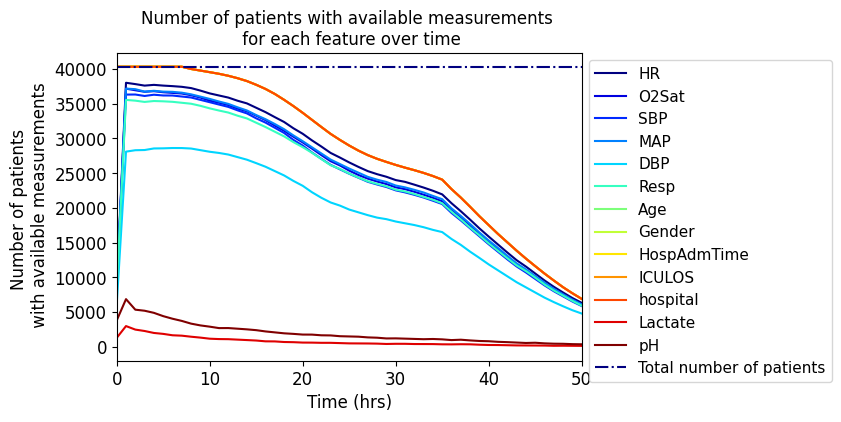

In [ ]:
# Plot popular measurements + augmented data
plt.figure(figsize=(6,4))
num_plots = len(list_popular_measurements)
colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, num_plots))))
for feature in list_popular_measurements:
  plt.plot(D[feature], label=feature)
plt.plot(num_patients_line, '-.',label='Total number of patients')
plt.legend(loc='upper left',bbox_to_anchor=(1, 1),fontsize=11)
plt.xlim([0,50])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time (hrs)',fontsize=12)
plt.ylabel('Number of patients \n with available measurements',fontsize=12)
plt.title('Number of patients with available measurements \n for each feature over time',fontsize=12)

In [ ]:
## Plot data for individual patient 0
# plt.plot(dataset.data[0,:,0],label='Heart rate')
# plt.plot(dataset.data[0,:,1],label='Systolic blood pressure')
# plt.plot(dataset.data[0,:,2],label='Mean Arterial blood pressure')
# plt.plot(dataset.data[0,:,3],label='Lactate')
# plt.plot(dataset.data[0,:,4],label='Temperature')
# plt.plot(dataset.data[0,:,5],label='Oxygen saturation')
# plt.plot(dataset.data[0,:,5],label='pH')
# plt.plot(dataset.data[0,:,5],label='Age')
# plt.plot(dataset.data[0,:,5],label='Age')
# plt.ylabel('Feature raw value')
# plt.legend(loc="lower right")
# plt.xlabel('Hours in ICU')

In [ ]:
# Only consider the popular + augmented measurements

#dataset = dataset.subset(list_popular_measurements)
#print(dataset.data.shape)

In [ ]:
# Hospital stay lengths
length_stay = torch.sum(~torch.isnan(dataset['ICULOS']), dim=1)
length_stay_ending_indices = torch.cumsum(length_stay,dim=0)
length_stay_list = list(np.array(length_stay.squeeze(1)))
length_stay_ending_indices_list = list(np.array(length_stay_ending_indices.squeeze(1)))

In [ ]:
# patient_labels_list = []
# prev_step = 0
# for patientID in num_patients:
#   current_step = length_stay_ending_indices_list[patientID]
#   patient_labels_list.append(torch.arange(prev_step,current_step))
#   prev_step = current_step
list_idx_labels = []
# for length in length_stay_ending_indices_list:
#   prev_step = 0
#   list_idx_labels.append(torch.arange(prev_step,length))
#   prev_step = length

# print(list_idx_labels[0])

# 3. Add "AvailMeas" feature to count which measurements are available at a specific time

In [ ]:
pd_see_nan_ovr_time = pd.DataFrame(dataset.data[:,0,:])
nan_counts_at_specific_time_over_feature = (~pd_see_nan_ovr_time.isna()).sum(axis=1)
#print(nan_counts_at_specific_time_over_feature)

In [ ]:
# Add count of available measurements
array_avail_feature_at_time_array = np.zeros_like(dataset.data[:,:,0])
for t_idx, time in enumerate(range(0,dataset.data.shape[1])):
  pd_see_nan_ovr_time = pd.DataFrame(dataset.data[:,t_idx,:])
  avail_feature_at_specific_time = (~pd_see_nan_ovr_time.isna()).sum(axis=1) #patient_num x 1
  array_avail_feature_at_time_array[:,t_idx] = avail_feature_at_specific_time

avail_feat_tensor = torch.tensor(array_avail_feature_at_time_array,dtype=torch.float32).unsqueeze(2)
print(avail_feat_tensor.shape)

dataset.add_features(avail_feat_tensor, columns=['AvailMeas'])
print(dataset.columns)
print(dataset.data.shape)
print('Check if any values in "AvailMeas" are missing: ',torch.any(torch.isnan(dataset['AvailMeas'])))

torch.Size([40336, 336, 1])
['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'hospital', 'AvailMeas']
torch.Size([40336, 336, 42])
Check if any values in "AvailMeas" are missing:  tensor(False)


In [ ]:
## Save data with available measurement
#torch.save(dataset,'data_with_availmeas.pt')

In [ ]:
# Open data from available measurement file
#dataset = torch.load('data_with_availmeas.pt')

# 4. Add "Time" as a feature to the dataset

In [ ]:
patients_in_data=dataset.data.shape[0]
hours=336
time_neuralCDE = torch.linspace(0, hours-1, steps=hours)
time_neuralCDE_unsqueezed = time_neuralCDE.unsqueeze(0).unsqueeze(-1).expand(patients_in_data,hours,1)
dataset['Time'] = time_neuralCDE_unsqueezed

# 5. Impute data (forward fill + fill in missing columns with zeros)

In [ ]:
dataset.data = torch_ffill(dataset.data)

/content/drive/MyDrive/CS229btimeseries/Project/sepsis_comp_physionet_2019/src/data/functions.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  data_ffilled = torch.Tensor([ffill2d(x.numpy().T) for x in data]).transpose(1, 2)


In [ ]:
## Save forward-filled data with time
#torch.save(dataset,'dataset_with_time_FF.pt')

In [ ]:
# Fill entire missing features with 0
dataset.data[torch.isnan(dataset.data)] = 0

In [ ]:
## Save forward-filled data with time
#torch.save(dataset,'dataset_with_time_FF_zeros.pt')

In [ ]:
len(dataset.columns)

43

In [ ]:
## Save forward-filled data without time
#torch.save(dataset,'dataset_FF_zeros.pt')

# 7A: With missing dataset add alll missing features

In [ ]:
dataset.columns

['HR',
 'O2Sat',
 'Temp',
 'SBP',
 'MAP',
 'DBP',
 'Resp',
 'EtCO2',
 'BaseExcess',
 'HCO3',
 'FiO2',
 'pH',
 'PaCO2',
 'SaO2',
 'AST',
 'BUN',
 'Alkalinephos',
 'Calcium',
 'Chloride',
 'Creatinine',
 'Bilirubin_direct',
 'Glucose',
 'Lactate',
 'Magnesium',
 'Phosphate',
 'Potassium',
 'Bilirubin_total',
 'TroponinI',
 'Hct',
 'Hgb',
 'PTT',
 'WBC',
 'Fibrinogen',
 'Platelets',
 'Age',
 'Gender',
 'Unit1',
 'Unit2',
 'HospAdmTime',
 'ICULOS',
 'hospital',
 'AvailMeas',
 'Time']

In [ ]:
print(len(dataset.columns))

43


In [ ]:
# dataset['maskHR'] = (~torch.isnan(dataset['HR'])).cumsum(dim=1)
# dataset['maskO2Sat'] = (~torch.isnan(dataset['O2Sat'])).cumsum(dim=1)
# dataset['maskTemp'] = (~torch.isnan(dataset['Temp'])).cumsum(dim=1)
# dataset['maskSBP'] = (~torch.isnan(dataset['SBP'])).cumsum(dim=1)
# dataset['maskMAP'] = (~torch.isnan(dataset['MAP'])).cumsum(dim=1)
# dataset['maskDBP'] = (~torch.isnan(dataset['DBP'])).cumsum(dim=1)


In [ ]:
print(len(dataset.columns))

49


In [ ]:
# dataset['maskResp'] = (~torch.isnan(dataset['Resp'])).cumsum(dim=1)
# dataset['maskEtCO2'] = (~torch.isnan(dataset['EtCO2'])).cumsum(dim=1)
# dataset['maskBaseExcess'] = (~torch.isnan(dataset['BaseExcess'])).cumsum(dim=1)
# dataset['maskHCO3'] = (~torch.isnan(dataset['HCO3'])).cumsum(dim=1)
# dataset['maskFiO2'] = (~torch.isnan(dataset['FiO2'])).cumsum(dim=1)
# dataset['maskpH'] = (~torch.isnan(dataset['pH'])).cumsum(dim=1)


In [ ]:
print(len(dataset.columns))

55


In [ ]:
# dataset['maskPaCO2'] = (~torch.isnan(dataset['PaCO2'])).cumsum(dim=1)
# dataset['maskSaO2'] = (~torch.isnan(dataset['SaO2'])).cumsum(dim=1)
# dataset['maskAST'] = (~torch.isnan(dataset['AST'])).cumsum(dim=1)
# dataset['maskBUN'] = (~torch.isnan(dataset['BUN'])).cumsum(dim=1)
# dataset['maskAlkalinephos'] = (~torch.isnan(dataset['Alkalinephos'])).cumsum(dim=1)
# dataset['maskCalcium'] = (~torch.isnan(dataset['Calcium'])).cumsum(dim=1)


In [ ]:
print(len(dataset.columns))

61


In [ ]:
# dataset['maskChloride'] = (~torch.isnan(dataset['Chloride'])).cumsum(dim=1)
# dataset['maskCreatinine'] = (~torch.isnan(dataset['Creatinine'])).cumsum(dim=1)
# dataset['maskBilirubin_direct'] = (~torch.isnan(dataset['Bilirubin_direct'])).cumsum(dim=1)
# dataset['maskTroponinI'] = (~torch.isnan(dataset['TroponinI'])).cumsum(dim=1)
# dataset['maskHct'] = (~torch.isnan(dataset['Hct'])).cumsum(dim=1)
# dataset['maskPTT'] = (~torch.isnan(dataset['PTT'])).cumsum(dim=1)


In [ ]:
print(len(dataset.columns))

67


In [ ]:
# dataset['maskWBC'] = (~torch.isnan(dataset['WBC'])).cumsum(dim=1)
# dataset['maskFibrinogen'] = (~torch.isnan(dataset['Fibrinogen'])).cumsum(dim=1)
# dataset['maskPlatelets'] = (~torch.isnan(dataset['Platelets'])).cumsum(dim=1)
# dataset['maskAge'] = (~torch.isnan(dataset['Age'])).cumsum(dim=1)


In [ ]:
print(len(dataset.columns))

71


In [ ]:
# dataset['maskGender'] = (~torch.isnan(dataset['Gender'])).cumsum(dim=1)
# dataset['maskUnit1'] = (~torch.isnan(dataset['Unit1'])).cumsum(dim=1)

In [ ]:
print(len(dataset.columns))

75


In [ ]:
# dataset['maskUnit2'] = (~torch.isnan(dataset['Unit2'])).cumsum(dim=1)
# dataset['maskHospAdmTime'] = (~torch.isnan(dataset['HospAdmTime'])).cumsum(dim=1)

In [ ]:
# dataset['maskICULOS'] = (~torch.isnan(dataset['ICULOS'])).cumsum(dim=1)
# dataset['maskhospital'] = (~torch.isnan(dataset['hospital'])).cumsum(dim=1)

In [ ]:
print(len(dataset.columns))

77


In [ ]:
# dataset['maskGlucose'] = (~torch.isnan(dataset['Glucose'])).cumsum(dim=1)
# dataset['maskLactate'] = (~torch.isnan(dataset['Lactate'])).cumsum(dim=1)
# dataset['maskMagnesium'] = (~torch.isnan(dataset['Magnesium'])).cumsum(dim=1)

In [ ]:
# dataset['maskPotassium'] = (~torch.isnan(dataset['Potassium'])).cumsum(dim=1)
# dataset['maskBilirubin_total'] = (~torch.isnan(dataset['Bilirubin_total'])).cumsum(dim=1)
# dataset['maskHgb'] = (~torch.isnan(dataset['Hgb'])).cumsum(dim=1)

In [ ]:
print(len(dataset.columns))

83


In [ ]:
#dataset['maskPhosphate'] = (~torch.isnan(dataset['Phosphate'])).cumsum(dim=1)

In [ ]:
print(len(dataset.columns))

84


In [ ]:
#Put yourself in project folder
%cd ../

/content/drive/MyDrive/CS229btimeseries/Project


In [ ]:
#torch.save(dataset, 'dataset_time_masks_missing_20231209.pt')

# 7b. Save labels for dataset

In [ ]:
import pickle

In [ ]:
%pwd #Put yourself in Project folder

'/content/drive/MyDrive/CS229btimeseries/Project'

In [ ]:
feature_name_folder='featurenames_CS229B_project/'
feature_name_file=feature_name_folder+'featlabel_dataset_time_masks_missing_20231209.pt'

In [ ]:
#folder='featurenames_sepsis_ds/'
#processed_dataset_name = folder+'dataset_subset_FF.pt'
#dataset = torch.load('dataset_time_masks_missing_20231206.pt')

In [ ]:
num_patients, num_timepoints, total_features = dataset.data.shape

In [ ]:
list_feature_names = dataset.columns

In [ ]:
print(list_feature_names)

['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'hospital', 'AvailMeas', 'Time', 'maskHR', 'maskO2Sat', 'maskTemp', 'maskSBP', 'maskMAP', 'maskDBP', 'maskResp', 'maskEtCO2', 'maskBaseExcess', 'maskHCO3', 'maskFiO2', 'maskpH', 'maskPaCO2', 'maskSaO2', 'maskAST', 'maskBUN', 'maskAlkalinephos', 'maskCalcium', 'maskChloride', 'maskCreatinine', 'maskBilirubin_direct', 'maskTroponinI', 'maskHct', 'maskPTT', 'maskWBC', 'maskFibrinogen', 'maskPlatelets', 'maskAge', 'maskGender', 'maskUnit1', 'maskUnit2', 'maskHospAdmTime', 'maskICULOS', 'maskhospital', 'maskGlucose', 'maskLactate', 'maskMagnesium', 'maskPotassium', 'maskBilirubin_total', 

In [ ]:
print(len(list_feature_names))

84


In [ ]:
# with open(feature_name_file, "wb") as fp:   #Pickling
#   pickle.dump(list_feature_names, fp)

Try to open file to check

In [ ]:
with open(feature_name_file, "rb") as fp:   # Unpickling
  b = pickle.load(fp)

print(b)

['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'hospital', 'AvailMeas', 'Time', 'maskHR', 'maskO2Sat', 'maskTemp', 'maskSBP', 'maskMAP', 'maskDBP', 'maskResp', 'maskEtCO2', 'maskBaseExcess', 'maskHCO3', 'maskFiO2', 'maskpH', 'maskPaCO2', 'maskSaO2', 'maskAST', 'maskBUN', 'maskAlkalinephos', 'maskCalcium', 'maskChloride', 'maskCreatinine', 'maskBilirubin_direct', 'maskTroponinI', 'maskHct', 'maskPTT', 'maskWBC', 'maskFibrinogen', 'maskPlatelets', 'maskAge', 'maskGender', 'maskUnit1', 'maskUnit2', 'maskHospAdmTime', 'maskICULOS', 'maskhospital', 'maskGlucose', 'maskLactate', 'maskMagnesium', 'maskPotassium', 'maskBilirubin_total', 

In [ ]:
print(len(b))

84


In [ ]:
# Check FF or not
torch.any(dataset.data.isnan())

tensor(True)

# 8. Cross validation
Want the same number of 'eventual sepsis' cases in each fold, and no patient being in more than one fold. The code below is simply ensuring this. (stratified kfold cv function from sepsis Physionet 2019 winner)

In [ ]:
# folder='featurenames_sepsis_ds/'
# filename='dataset_subset_five_features_time_avail_hospital_mask.pt'
# dataset = torch.load(folder+filename)

In [ ]:
%cd ../
! pwd

/content/drive/MyDrive/CS229btimeseries/Project
/content/drive/MyDrive/CS229btimeseries/Project


In [ ]:
dataset = torch.load('dataset_time_masks_missing_20231209.pt')

In [ ]:
num_patients, num_timepoints, total_features = dataset.data.shape

In [ ]:
print(dataset.data.shape)

torch.Size([40336, 336, 84])


In [ ]:
data_list_variable_time = dataset.to_list()

In [ ]:
# Using given code
# Get the id-indexed CV fold. We need both patient indexes and time index.
# 2/3 train, 1/6 test/ 1/6val
cv, id_cv = stratified_kfold_cv(dataset, labels, n_splits=4, return_as_list=True, seed=1) #seed=1
train_idxs, val_test_idxs = cv[0] #time index
train_id_idxs, val_test_id_idxs = id_cv[0] #patient index

In [ ]:
# my modification to get validation set as well (half to train dataset)
num_patients_train = len(train_idxs)
num_patients_val_and_test = len(val_test_idxs)
end_idx_val = int(num_patients_val_and_test/2)

val_idxs = val_test_idxs[:end_idx_val]
val_id_idxs = val_test_id_idxs[:end_idx_val]
test_idxs = val_test_idxs[end_idx_val:]
test_id_idxs = val_test_id_idxs[end_idx_val:]

# Make train and test data
train_data = np.array([np.array(dataset.data[i].detach()) for i in train_id_idxs.tolist()])#patient index
variable_length_train_labels = [np.array(labels[i].detach()) for i in train_idxs] #time index

val_data = np.array([np.array(dataset.data[i].detach()) for i in val_id_idxs.tolist()])
variable_length_val_labels = [np.array(labels[i].detach()) for i in val_idxs]

test_data = np.array([np.array(dataset.data[i].detach()) for i in test_id_idxs.tolist()])
variable_length_test_labels = [np.array(labels[i].detach()) for i in test_idxs]

In [ ]:
print("Train data shape: ", train_data.shape)
print("Val data shape: ", val_data.shape)
print("Test data shape: ", test_data.shape)


Train data shape:  (30252, 336, 84)
Val data shape:  (5042, 336, 84)
Test data shape:  (5042, 336, 84)


In [ ]:
num_timepoints=336

In [ ]:
def pad_sepsis_label_with_last_value(array_of_patient_labels, desired_length_array):
  C = np.zeros(desired_length_array)
  last_val = array_of_patient_labels[-1:]
  padded_array = np.pad(array_of_patient_labels, (0,len(C)-len(array_of_patient_labels)),constant_values=last_val)
  return padded_array

same_length_train_labels_padded = np.array([pad_sepsis_label_with_last_value(patient_label, num_timepoints) for patient_label in variable_length_train_labels])
same_length_val_labels_padded = np.array([pad_sepsis_label_with_last_value(patient_label, num_timepoints) for patient_label in variable_length_val_labels])
same_length_test_labels_padded = np.array([pad_sepsis_label_with_last_value(patient_label, num_timepoints) for patient_label in variable_length_test_labels])

In [ ]:
print(same_length_train_labels_padded.shape)

(30252, 336)


In [ ]:
num_patients_that_are_septic = np.count_nonzero(np.sum(same_length_train_labels_padded,axis=1))
print("Number of patients that are septic in training: ", num_patients_that_are_septic)
print("total number of patients in training: ", train_data.shape[0])
print("\n")
vnum_patients_that_are_septic = np.count_nonzero(np.sum(same_length_val_labels_padded,axis=1))
print("Number of patients that are septic in test: ", vnum_patients_that_are_septic)
print("total number of patients in val: ", val_data.shape[0])
print("\n")
tnum_patients_that_are_septic = np.count_nonzero(np.sum(same_length_test_labels_padded,axis=1))
print("Number of patients that are septic in test: ", tnum_patients_that_are_septic)
print("total number of patients in test: ", test_data.shape[0])

Number of patients that are septic in training:  2199
total number of patients in training:  30252


Number of patients that are septic in test:  431
total number of patients in val:  5042


Number of patients that are septic in test:  302
total number of patients in test:  5042


# 9. Fix the imbalanced data problem (my extension)

In [ ]:
#https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = numpy.random.permutation(len(a))
    return a[p], b[p]


In [ ]:
def balance_septic_data(patient_data, septic_label, factor_nonsepsis):
  all_patient_indices = np.arange(patient_data.shape[0])

  indicated_sepsis_labels = np.sum(septic_label,axis=1)
  id_septic_patient = np.nonzero(indicated_sepsis_labels)[0]
  id_non_septic_patient = np.array([idx for idx,val in enumerate(septic_label) if idx not in id_septic_patient])

  # Randomly sample indices of some of the non-septic patients
  random_id_non_septic = np.random.choice(id_non_septic_patient, size=(int(factor_nonsepsis*len(id_septic_patient))), replace=False)
  print('Number of randomly sampled non-septic patients', len(random_id_non_septic))
  # Get septic and nonseptic data
  septic_patient_data = np.array([np.array(patient_data[i]) for i in id_septic_patient])
  only_septic_patient_label = np.array([np.array(septic_label[i]) for i in id_septic_patient])
  non_septic_patient_data = np.array([np.array(patient_data[i]) for i in random_id_non_septic])
  non_septic_patient_label = np.array([np.array(septic_label[i]) for i in random_id_non_septic])

  # Merge into patient_data, septic_label
  balanced_patient_data = np.vstack((septic_patient_data,non_septic_patient_data))
  balanced_septic_label = np.vstack((only_septic_patient_label,non_septic_patient_label))
  print('Input data shape', balanced_patient_data.shape)
  print('Output labels shape', balanced_septic_label.shape)

  balanced_patient_data,  balanced_septic_label = unison_shuffled_copies(balanced_patient_data, balanced_septic_label)
  return balanced_patient_data, balanced_septic_label

In [ ]:
train_data, same_length_train_labels_padded = balance_septic_data(train_data, same_length_train_labels_padded,1.5)
val_data, same_length_val_labels_padded = balance_septic_data(val_data, same_length_val_labels_padded,1.5)
test_data, same_length_test_labels_padded = balance_septic_data(test_data, same_length_test_labels_padded,1.5)

Number of randomly sampled non-septic patients 3298
Input data shape (5497, 336, 84)
Output labels shape (5497, 336)
Number of randomly sampled non-septic patients 646
Input data shape (1077, 336, 84)
Output labels shape (1077, 336)
Number of randomly sampled non-septic patients 453
Input data shape (755, 336, 84)
Output labels shape (755, 336)


In [ ]:
num_patients_that_are_septic = np.count_nonzero(np.sum(same_length_train_labels_padded,axis=1))
print("Number of patients that are septic in training: ", num_patients_that_are_septic)
print("total number of patients in training: ", train_data.shape[0])
print("\n")
vnum_patients_that_are_septic = np.count_nonzero(np.sum(same_length_val_labels_padded,axis=1))
print("Number of patients that are septic in test: ", vnum_patients_that_are_septic)
print("total number of patients in val: ", val_data.shape[0])
print("\n")
tnum_patients_that_are_septic = np.count_nonzero(np.sum(same_length_test_labels_padded,axis=1))
print("Number of patients that are septic in test: ", tnum_patients_that_are_septic)
print("total number of patients in test: ", test_data.shape[0])


Number of patients that are septic in training:  2199
total number of patients in training:  5497


Number of patients that are septic in test:  431
total number of patients in val:  1077


Number of patients that are septic in test:  302
total number of patients in test:  755


In [ ]:
print(same_length_train_labels_padded.shape)
print(same_length_val_labels_padded.shape)
print(same_length_test_labels_padded.shape)

(5497, 336)
(1077, 336)
(755, 336)


# 10. Save train/val/test data + labels

In [ ]:
%cd ../

/content/drive/MyDrive/CS229btimeseries/Project


In [ ]:
train_folder='train_val_test_sepsis_datasets/'

In [ ]:
#torch.save(train_data,train_folder+'train_data_missing_t_masks_unscaled_20231209.pt')
#torch.save(val_data,train_folder+'val_data_missing_t_masks_unscaled_20231209.pt')
#torch.save(test_data,train_folder+'test_data_missing_t_masks_unscaled_20231209.pt')

In [ ]:
#torch.save(same_length_train_labels_padded, train_folder+'train_targets_missing_t_masks_unscaled_20231209.pt')
#torch.save(same_length_val_labels_padded, train_folder+'val_targets_missing_t_masks_unscaled_20231209.pt')
#torch.save(same_length_test_labels_padded, train_folder+'test_targets_missing_t_masks_unscaled_20231209.pt')

# BEYOND 11. Scale feature matrix and set batch size

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
# Scale the feature data from 0 to 1
def get_scaler(scaler):
    """Apply scalar transformation to features"""
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

# SET BATCH SIZE

In [ ]:
batch_size=512
num_features = train_data.shape[2]
print(num_features)

43


In [ ]:
# Scale features
scaler = get_scaler('minmax')
num_instances, num_time_steps, num_features = train_data.shape
train_data_unrolled = np.reshape(train_data, newshape=(-1, num_features))
train_data_scaled_unrolled = scaler.fit_transform(train_data_unrolled)
print(train_data_scaled_unrolled.shape)
train_data_scaled = np.reshape(train_data_scaled_unrolled, newshape=(num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = val_data.shape
val_data_unrolled = np.reshape(val_data, newshape=(-1, num_features))
val_data_scaled_unrolled = scaler.transform(val_data_unrolled)
val_data_scaled = np.reshape(val_data_scaled_unrolled, newshape=(num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = test_data.shape
test_data_unrolled = np.reshape(test_data, newshape=(-1, num_features))
test_data_scaled_unrolled = scaler.transform(test_data_unrolled)
test_data_scaled = np.reshape(test_data_scaled_unrolled, newshape=(num_instances, num_time_steps, num_features))

print(train_data_scaled.shape)
print(val_data_scaled.shape)
print(test_data_scaled.shape)

NameError: ignored

In [ ]:
print(train_data_scaled[0][1])

[0.3452915  0.91999996 0.         0.44481605 0.25167784 0.18815331
 0.16       0.         0.4375     0.         0.90826523 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.77904767 1.
 0.         0.         0.99503183 0.00597015 0.         0.28947368]


# 12. Convert train, val, and test scaled feature matrices and labels to torch tensors

In [ ]:
# Convert train, val, and test outputs and inputs to torch tensors
train_data_scaled = torch.tensor(train_data_scaled, dtype=torch.float32)
val_data_scaled = torch.tensor(val_data_scaled, dtype=torch.float32)
test_data_scaled = torch.tensor(test_data_scaled, dtype=torch.float32)

train_labels = torch.tensor(same_length_train_labels_padded, dtype=torch.int64)
val_labels = torch.tensor(same_length_val_labels_padded, dtype=torch.int64)
test_labels = torch.tensor(same_length_test_labels_padded, dtype=torch.int64)

In [ ]:
print(train_labels.shape)

torch.Size([5497, 336])
